In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset


C:\Users\roger\AppData\Local\Temp\ipykernel_12676\2816518301.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


## Create Data

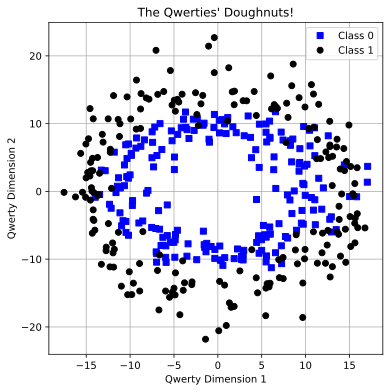

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 🔹 ক্লাস্টার সংখ্যা
nPerClust = 200

# 🔹 কোণ এবং রেডিয়াস
th = np.linspace(0, 4*np.pi, nPerClust)
r1 = 10
r2 = 15

# 🔹 প্রথম ডোনাট ক্লাস্টার (a)
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3,
      r1*np.sin(th) + np.random.randn(nPerClust) ]

# 🔹 দ্বিতীয় ডোনাট ক্লাস্টার (b)
b = [ r2*np.cos(th) + np.random.randn(nPerClust),
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# 🔹 labels তৈরি করা
labels_np = np.vstack((
    np.zeros((nPerClust, 1)),
    np.ones((nPerClust, 1))
))

# 🔹 ডেটা মিশ্রিত করে
data_np = np.hstack((a, b)).T

# 🔹 টেন্সরে রূপান্তর
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# 🔹 ভিজুয়ালাইজেশন
fig = plt.figure(figsize=(6,6))
plt.plot(data[labels[:,0]==0,0], data[labels[:,0]==0,1], 'bs', label='Class 0')
plt.plot(data[labels[:,0]==1,0], data[labels[:,0]==1,1], 'ko', label='Class 1')
plt.title("The Qwerties' Doughnuts!")
plt.xlabel('Qwerty Dimension 1')
plt.ylabel('Qwerty Dimension 2')
plt.legend()
plt.grid(True)
plt.show()


### Separate the data into DataLoaders

In [19]:
from sklearn.model_selection import train_test_split

# Split into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=0.8, stratify=labels)

# Create TensorDatasets
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=test_ds.tensors[0].shape[0])

# Check a batch from the train loader
for batch_data, batch_labels in train_loader:
    print("Batch shape:", batch_data.shape)
    print("Labels shape:", batch_labels.shape)
    break


Batch shape: torch.Size([16, 2])
Labels shape: torch.Size([16, 1])


#### Create the Model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        self.input = nn.Linear(2, 128)
        self.hidden = nn.Linear(128, 128)
        self.output = nn.Linear(128, 1)  # ✅ fix: input 128, output 1

        self.dr = dropoutRate

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        x = F.relu(self.hidden(x))
        x = F.dropout(x, p=self.dr, training=self.training)

        x = self.output(x)  # no activation for logits; apply sigmoid in loss or outside if needed
        return x


In [21]:
tmpnet=theModelClass(.25)

tmpdata= torch.rand((10,2))
yhat=tmpnet(tmpdata)
yhat

tensor([[0.0991],
        [0.2578],
        [0.1642],
        [0.2184],
        [0.2147],
        [0.1781],
        [0.2173],
        [0.1629],
        [0.1609],
        [0.0548]], grad_fn=<AddmmBackward0>)

### Functions to create and train the net

In [22]:
def createANewModel(dropoutrate):

    ANNQC= theModelClass(dropoutrate)

    lossfun= nn.BCEWithLogitsLoss()

    optimizer= torch.optim.SGD(ANNQC.parameters(),lr=.002)

    return ANNQC,lossfun,optimizer





In [23]:
##train the model

numepochs=1000

def trainTheModel(ANNQC,lossfun,optimizer):
    trainAcc=[]
    testAcc=[]

    

    for epochi in range(numepochs):
        ANNQC.train()
        batchAcc=[]

        for X,y in train_loader:

            yHat=ANNQC(X)
            loss=lossfun(yHat,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

            batchAcc.append(100*torch.mean(((yHat>.5)==y).float()).item())

            trainAcc.append(np.mean(batchAcc))

            ANNQC.eval()
            X,y=next(iter(test_loader))
            yHat=ANNQC(X)
            testAcc.append(100*torch.mean(((yHat>.5)==y).float()).item())

        return trainAcc,testAcc

### Test the model

In [24]:
dropoutrate=.0
ANNQC,lossfun,optimizer=createANewModel(dropoutrate)

trainAcc,testAcc=trainTheModel(ANNQC,lossfun,optimizer)

In [25]:
def smooth(x,k=5):
    return np.convolve(x,np.ones(k)/k,mode='same')

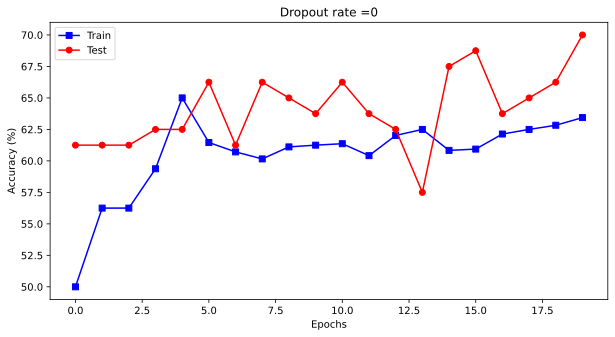

In [29]:
fig=plt.figure(figsize=(10,5))

plt.plot(trainAcc, 'bs-')
plt.plot(testAcc, 'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate =%g'%dropoutrate)

plt.show()

## Experiment the Code


In [31]:
dropoutRates=np.arange(10)/10
results=np.zeros((len(dropoutRates),2))

for di in range(len(dropoutRates)):

    ANNQC,lossfun,optimizer=createANewModel(dropoutRates[di])
    trainAcc,testAcc=trainTheModel(ANNQC,lossfun,optimizer)

    results[di,0]=np.mean(trainAcc[-100:])
    results[di,1]=np.mean(testAcc[-100:])

Text(0, 0.5, 'Train Test difference (acc%)')

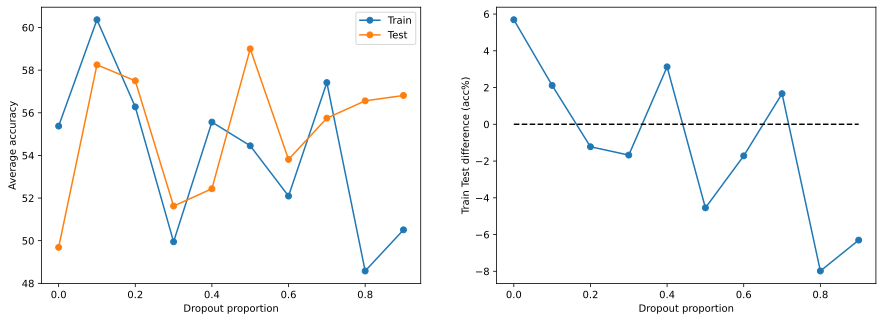

In [32]:
fig,ax=plt.subplots(1,2,figsize=(15,5))

ax[0].plot(dropoutRates,results,'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train','Test'])


ax[1].plot(dropoutRates,-np.diff(results,axis=1),'o-')
ax[1].plot([0,.9],[0,0],'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train Test difference (acc%)')
